# Using R with Amazon SageMaker

In this lab, you will use Amazon SageMaker to train, deploy, and retrieve predictions from a machine learning (ML) model using the NYC Taxicab dataset that you queries in the Athena lab.

Our goal is to create a simple linear regression model that predicts the tip that a passenger will leave based upon the trip distance and the number of passengers in the vehicle.


### JSONlite
We will be using the jsonlite package to convert the SageMaker JSON output back into a matrix towards the end of this lab.  That package is not part of the standard packages loaded by the SageMaker R kernel, so we must install it from CRAN and then load it.

In [1]:
# Install jsonlite for JSON processing
install.packages("jsonlite")
library(jsonlite)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Installing and Loading Packages

### TicToc
We will be using the tictoc package to time some of the steps in this lab.  That package is not part of the standard packages loaded by the SageMaker R kernel, so we must install it from CRAN and then load it.

In [2]:
# Install TicToc to measure code running time
install.packages('tictoc', repos='http://cran.us.r-project.org')
library(tictoc)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Tidyverse
The Tidyverse, on the other hand, is a standard SageMaker package, so we can load it directly.  We first have to set the timezone to avoid some error messages that occur if the timezone is not set.

In [3]:
Sys.setenv(TZ='GMT')
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Reticulating the Amazon SageMaker Python SDK

The SageMaker SDK is written in Python.  Fortunately, R provides a very convenient package called `reticulate`  that allows you to load Python modules in your R code.  We will load the `reticulate` library and then import the `sagemaker` Python module.

In [4]:
library(reticulate)
sagemaker <- import('sagemaker')

## Creating and accessing the data storage

The `Session` class provides operations for working with the following [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) resources with Amazon SageMaker:

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

Let's create an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) bucket for your data.

Note that here we use the `$` operator to access objects and methods from the Python module.

In [5]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**Note** - The `default_bucket` function creates a unique Amazon S3 bucket with the following name:

`sagemaker-<aws-region-name>-<aws account number>`

Specify the IAM role's [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:

In [6]:
role_arn <- sagemaker$get_execution_role()

## Downloading the NYC Taxi Dataset

The model uses the [NYC Taxi Dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) that you may download directly from the City of New York.  

To simplify the analysis in this lab, we will work with only one month of data.  You may use the December 2018 data stored here:

https://itao-datasets.s3.amazonaws.com/nyc-taxi/yellow_tripdata_2018-12.csv

The code below provides an example of using the `tic()` and `toc()` functions to time an operation.  In this case, it is simply timing a 10-second sleep operation.  Replace the `Sys.sleep(10)` function call with the code requried to load the data into a dataset named `taxi`.  Then use the `head()` function to display the first six lines of the file and verify that they were loaded in correctly.


In [7]:
tic('Reading Data')
# Replace the line below
taxi  <- read_csv("https://itao-datasets.s3.amazonaws.com/nyc-taxi/yellow_tripdata_2018-12.csv")
toc()

head(taxi)

Rows: 8173231 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): store_and_fwd_flag
dbl  (14): VendorID, passenger_count, trip_distance, RatecodeID, PULocationI...
dttm  (2): tpep_pickup_datetime, tpep_dropoff_datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Reading Data: 30.552 sec elapsed


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,12.0,0.5,0.5,3.95,0,0.3,17.25
1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,13.0,0.5,0.5,2.85,0,0.3,17.15
2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,2.5,0.5,0.5,0.00,0,0.3,3.80
1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,12.5,0.5,0.5,2.75,0,0.3,16.55
1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,45.0,0.5,0.5,9.25,0,0.3,55.55
1,2018-12-01 00:00:38,2018-12-01 00:29:26,1,18.8,1,N,132,97,1,50.5,0.5,0.5,10.35,0,0.3,62.15


## Exploratory Data Analysis

Next, write code to view the statistical summary of the dataset:

In [8]:
summary(taxi)

    VendorID     tpep_pickup_datetime            
 Min.   :1.000   Min.   :2003-12-23 05:01:51.00  
 1st Qu.:1.000   1st Qu.:2018-12-07 23:13:07.00  
 Median :2.000   Median :2018-12-14 22:11:21.00  
 Mean   :1.635   Mean   :2018-12-15 09:13:48.66  
 3rd Qu.:2.000   3rd Qu.:2018-12-21 20:14:23.00  
 Max.   :4.000   Max.   :2020-12-10 20:34:26.00  
 tpep_dropoff_datetime            passenger_count trip_distance    
 Min.   :2003-12-23 05:09:00.00   Min.   :0.000   Min.   :  0.000  
 1st Qu.:2018-12-07 23:31:25.00   1st Qu.:1.000   1st Qu.:  0.930  
 Median :2018-12-14 22:31:32.00   Median :1.000   Median :  1.600  
 Mean   :2018-12-15 09:32:33.65   Mean   :1.596   Mean   :  2.893  
 3rd Qu.:2018-12-21 20:31:45.00   3rd Qu.:2.000   3rd Qu.:  2.990  
 Max.   :2020-12-10 20:54:46.00   Max.   :9.000   Max.   :602.300  
   RatecodeID     store_and_fwd_flag  PULocationID    DOLocationID  
 Min.   : 1.000   Length:8173231     Min.   :  1.0   Min.   :  1.0  
 1st Qu.: 1.000   Class :character  

There are certainly some strange values in this dataset.  In our analysis, we are going to focus on the variables `tip_amount`, `trip_distance`, and `passenger_count`.

Create a visualization of these variables using `ggplot()` to assist with your analysis.  Note that this dataset contains a row for each trip taken in an NYC taxi that month.  This is millions of trips.  You should not try to visualize the entire dataset, as this will take quite a long time.  Try using the `sample_n()` function to pick a random sample of 10,000 records to visualize.

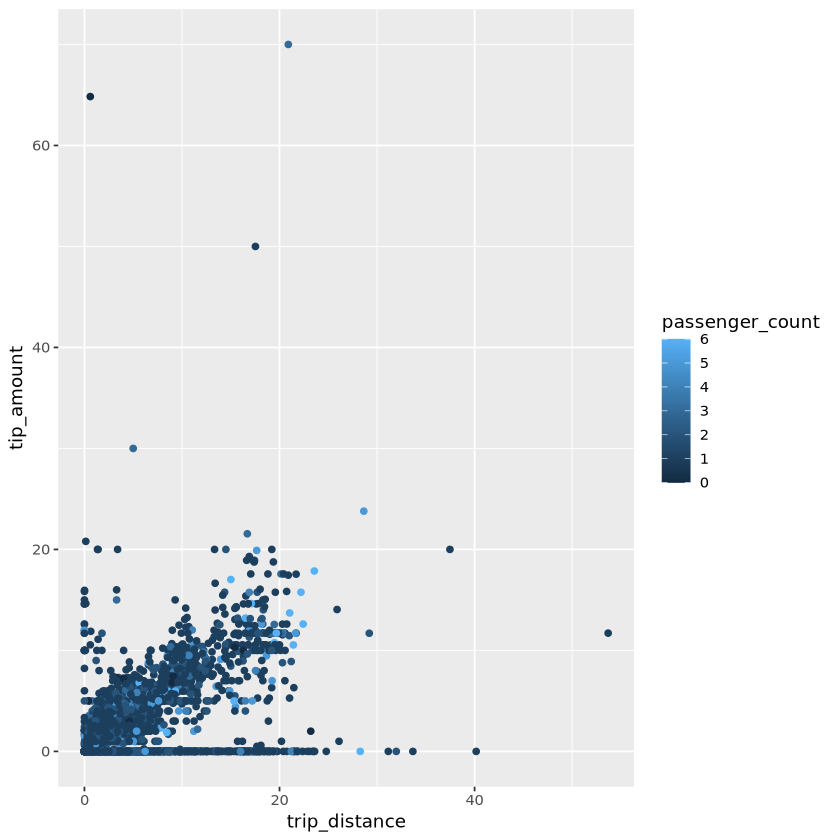

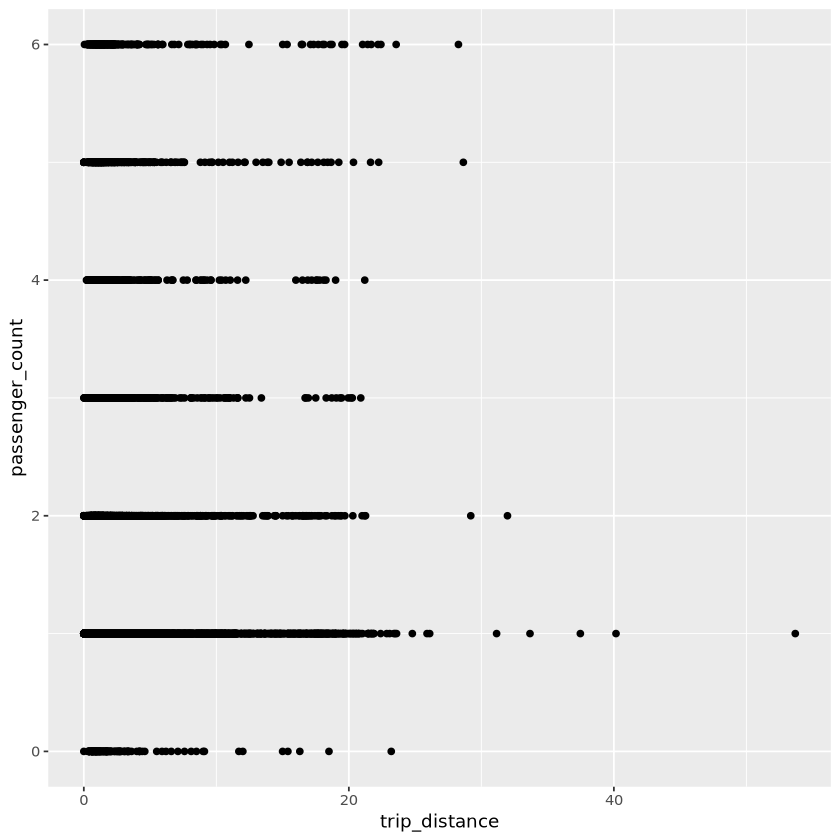

In [9]:
sample_taxi <- sample_n(taxi,10000)

ggplot(data=sample_taxi, mapping = aes(x=trip_distance, y=tip_amount))+
  geom_point(mapping = aes(color=passenger_count))


ggplot(data=sample_taxi, mapping = aes(x=trip_distance, y=passenger_count))+
  geom_point()

### Exploratory Analysis

Considering only the three variables of interest for our analysis, provide a bulleted list of anomalies that you observe:



In [10]:
#1. Outlier in Tip
#2. Less than zero tip
#3 tip distance >100
#4. passenger count of zero

## Cleaning the Dataset

Using `dplyr` code, clean your dataset.  Remove rows to resolve the anomalies that you identified above and then reduce the columns in your dataset down to only the three variables of interest.  Be sure that `tip_amount` is the first variable in the dataset.  When we later train the model, the training algorithm will assume that the first column contains the dependent variable.

In [11]:
# Insert your code here

select_taxi <- taxi %>% 
select(tip_amount,passenger_count,trip_distance)

select_taxi <- select_taxi %>% 
filter(tip_amount<90,
      tip_amount>0,
      trip_distance<100,
      passenger_count!=0)

summary(select_taxi)

   tip_amount     passenger_count trip_distance  
 Min.   : 0.010   Min.   :1.000   Min.   : 0.00  
 1st Qu.: 1.450   1st Qu.:1.000   1st Qu.: 1.00  
 Median : 2.040   Median :1.000   Median : 1.65  
 Mean   : 2.856   Mean   :1.602   Mean   : 2.93  
 3rd Qu.: 3.160   3rd Qu.:2.000   3rd Qu.: 3.00  
 Max.   :89.120   Max.   :9.000   Max.   :94.70  

Rerun the visualization that you created earlier and inspect it to determine whether your cleaning code was effective.

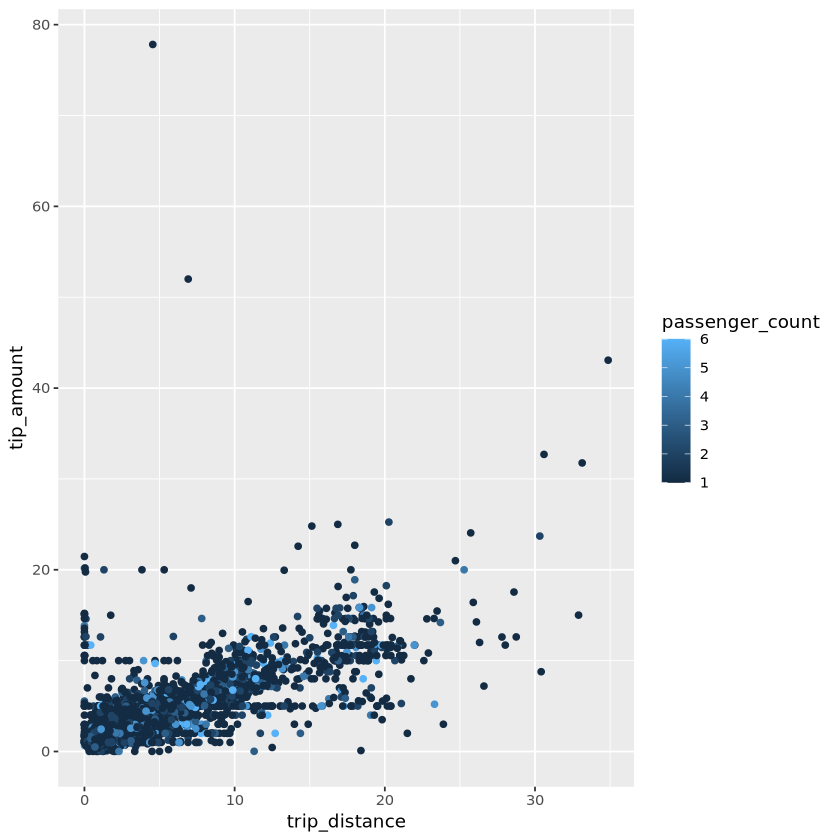

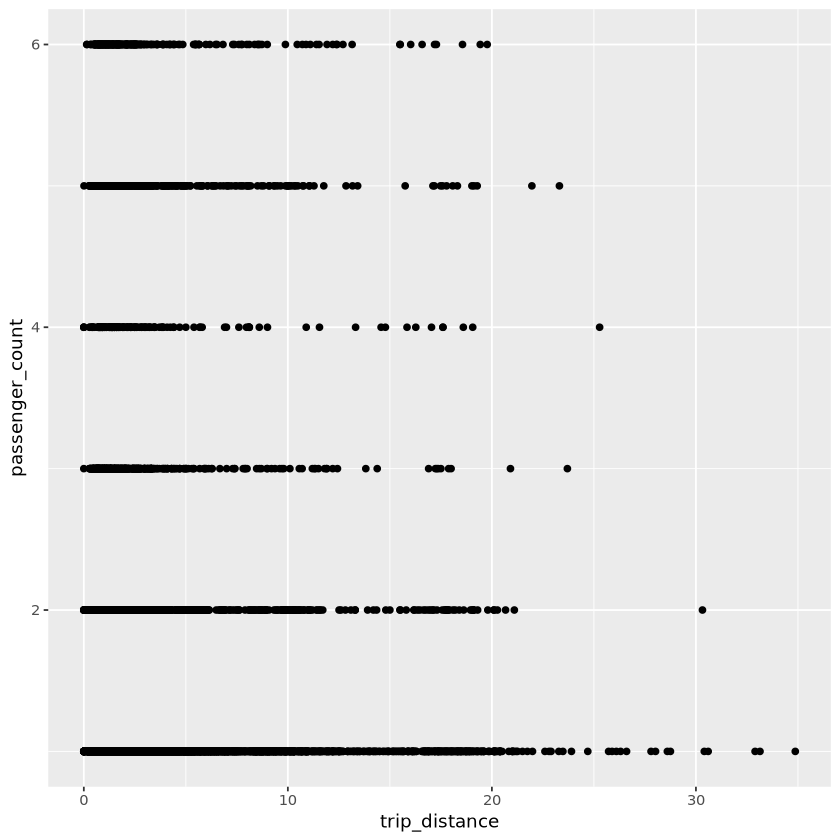

In [12]:
select_sample_taxi <- sample_n(select_taxi,10000)
ggplot(data=select_sample_taxi, mapping = aes(x=trip_distance, y=tip_amount))+
  geom_point(mapping = aes(color=passenger_count))


ggplot(data=select_sample_taxi, mapping = aes(x=trip_distance, y=passenger_count))+
  geom_point()

## Splitting the Dataset

We need two datasets for our analysis: a training dataset and a test dataset.

Create these datasets and name them `taxi_train` and `taxi_test`.

The training dataset should contain 25% of the rows in your existing dataset, selected randomly.  Consider using the `sample_frac()` function.  

The testing dataset should each contain 2% of the rows from your dataset.  Note that we would normally use much more data than this.  We are reducing the size of our dataset just to make the analysis run more quickly.

At the conclusion of your cleaning, use the `nrow()` function on each of the three datasets to show the size of each dataset.

In [13]:
taxi_train <- sample_frac(select_taxi, .25)
nrow(taxi_train)

taxi_test <- sample_frac(select_taxi,.02)
nrow(taxi_test)

nrow(select_sample_taxi)

[1] 1311807

[1] 104945

[1] 10000

Upload the training data to Amazon S3 so that you can train the model. First, write the training and validation datasets to the local filesystem in .csv format:

In [14]:
write_csv(taxi_train, 'taxi_train.csv', col_names = FALSE)

Second, upload the two datasets to the Amazon S3 bucket into the `data` key:

In [15]:
s3_train <- session$upload_data(path = 'taxi_train.csv',
                                bucket = bucket,
                                key_prefix = 'data')

Finally, define the Amazon S3 input types for the Amazon SageMaker algorithm:

In [16]:
s3_train_input <- sagemaker$session$s3_input(s3_data = s3_train,
                                     content_type = 'text/csv')


## Training the model

Amazon SageMaker algorithm are available via a [Docker](https://www.docker.com/) container. To train a linear model, we can use the [linear-learner](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) algorithm.  The code below finds the location of the appropriate Docker container.

In [17]:
registry <- sagemaker$amazon$amazon_estimator$get_image_uri(
    region_name=session$boto_region_name,
    repo_name='linear-learner',
    repo_version='latest')

container <- paste(registry)
container

[1] "382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1"

The code below defines an Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html), which can train any supplied algorithm that has been containerized with Docker. When creating the Estimator, use the following arguments:
* **image_name** - The container image to use for training
* **role** - The Amazon SageMaker service role
* **train_instance_count** - The number of Amazon EC2 instances to use for training
* **train_instance_type** - The type of Amazon EC2 instance to use for training
* **train_volume_size** - The size in GB of the [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) volume to use for storing input data during training
* **train_max_run** - The timeout in seconds for training
* **input_mode** - The input mode that the algorithm supports
* **output_path** - The Amazon S3 location for saving the training results (model artifacts and output files)
* **output_kms_key** - The [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS) key for encrypting the training output
* **base_job_name** - The prefix for the name of the training job
* **sagemaker_session** - The Session object that manages interactions with Amazon SageMaker API

In [18]:
s3_output <- paste0('s3://', bucket, '/output')
estimator <- sagemaker$estimator$Estimator(image_uri= container,
                                           role = role_arn,
                                           instance_count = 1L,
                                           instance_type =  'ml.c5.4xlarge',
                                           volume_size = 30L,
                                           max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = session)

The code below specifies the [linear-learner hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html) and fits the model.

In [19]:
tic("Model Fitting")
estimator$set_hyperparameters(predictor_type='regressor')
job_name <- paste('sagemaker-train-linear', format(Sys.time(), '%H-%M-%S'), sep = '-')
input_data <- list('train' = s3_train_input)

estimator$fit(inputs = input_data,
              job_name = job_name)
toc()

Model Fitting: 283.071 sec elapsed


Once training has finished, Amazon SageMaker copies the model binary (a gzip tarball) to the specified Amazon S3 output location. Get the full Amazon S3 path with this command:

In [20]:
estimator$model_data

[1] "s3://sagemaker-us-east-1-905359333010/output/sagemaker-train-linear-23-01-10/output/model.tar.gz"

## Deploying the model

Amazon SageMaker lets you [deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request. Let's deploy our trained model to a `ml.m5.large` instance.

In [21]:
tic("Model Deployment")
model_endpoint <- estimator$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.m5.large')


## Generating predictions with the model

Use the test data to generate predictions. Pass comma-separated text to be serialized into JSON format by specifying `text/csv` and `csv_serializer` for the endpoint:

In [22]:
# Specify csv_serializer
model_endpoint$serializer <- sagemaker$serializers$CSVSerializer()

# Drop the first row
taxi_test_data <- taxi_test[-1]
head(taxi_test_data)
# This now works > 500
test_sample <- as.matrix(taxi_test_data[1:nrow(taxi_test_data), ])
dimnames(test_sample)[[2]] <- NULL

predictions <- model_endpoint$predict(test_sample)
toc()

passenger_count,trip_distance
<dbl>,<dbl>
1,1.98
1,1.05
1,1.40
1,14.71
5,0.79
2,4.60


Model Deployment: 243.555 sec elapsed


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


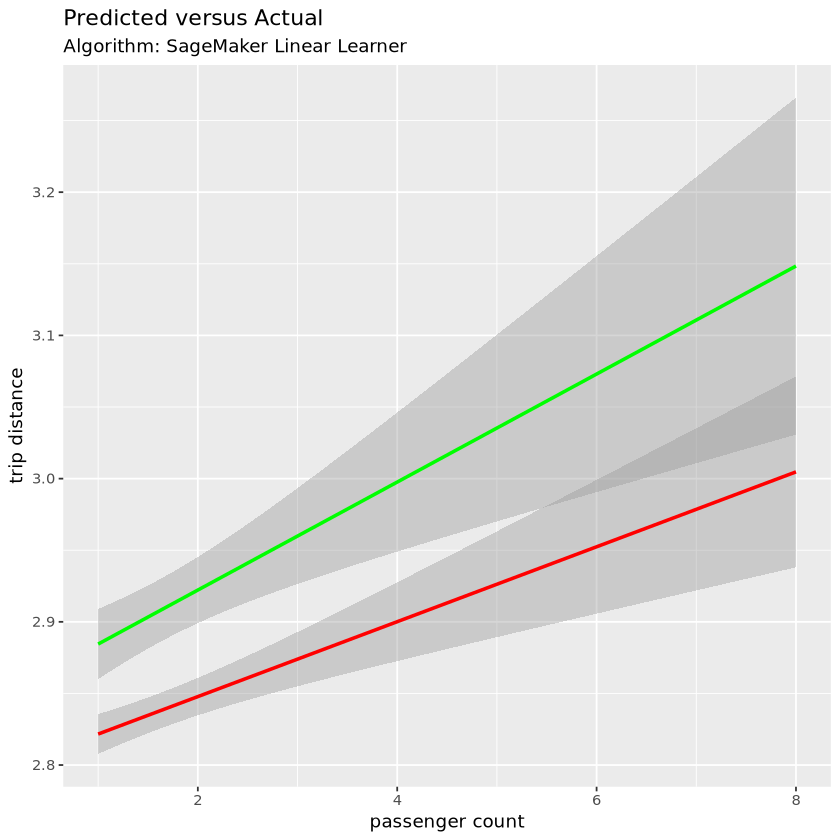

In [23]:
# Now that we have the predictions,
# convert to ASCII
my_pred <- iconv(predictions, to='ASCII')

# convert from JSON to a matrix
pred_matrix <- as.matrix(unlist(fromJSON(my_pred)))
# Get rid of the row names
rownames(pred_matrix) <- NULL

# Append the predictions to the test_sample matrix
combined_matrix <- cbind(test_sample, pred_matrix)

# Plot the results
test_sample_pred <- as_tibble(combined_matrix)

# Add labels and whatnot
test_sample_pred %>%
   ggplot() +
      geom_smooth(aes(x = V1, y = V2), formula = y ~ x, method = "lm", se = TRUE, color='green') +
      geom_smooth(aes(x = V1, y = V3), formula = y ~ x, method = "lm", se = TRUE, color='red') +
      ggtitle("Predicted versus Actual",subtitle="Algorithm: SageMaker Linear Learner") +
      xlab("passenger count") +
      ylab("trip distance")



<h3>Deleting the endpoint</h3>

When you're done with the model, delete the endpoint to avoid incurring deployment costs:

In [24]:
session$delete_endpoint(model_endpoint$endpoint)

## Lab Analysis

Edit the Markdown below to provide your answers to these lab analysis questions.

### Time Consumed

How much time did you consume using each of these instance categories?  You should be able to identify the exact time for the training instance.  For the endpoint instance, you may use the combined times to create the endpoint and to evaluate the predictions.  For the notebook instance, make your best estimate of how long you were running an active notebook instance, combining multiple sessions if applicable.

Notebook instance:32.372 seconds

Training instance:283.137 seconds

Evaluation endpoint instance: 584.004 seconds

### Lab Cost

Determine the cost of running this lab. You can find the instance pricing on the [SageMaker pricing](https://aws.amazon.com/sagemaker/pricing/) page.  Note that your notebook instance also uses an EBS volume.


Notebook instance: (32.372/3600) x $0.10 = $0.000899

Training instance:  (283.137/3600) x $0.922 = $0.0725

Evaluation endpoint instance: (584.004/3600) x $0.115 = $0.0187

Total cost = $0.09

### SageMaker Tool Evaluation

Think about the use of SageMaker in a real-world analytics environment.  When would it be appropriate to use this type of tool?  When might SageMaker not be a good choice?  Provide a discussion of this topic using examples drawn from either your own experience or a fictitious (yet reasonable) example.

Sagemaker would be best for a company that might not have the biggest budget to run large machine learning alogrithms on their data. In this lab, we were able  to upload a csv file using a jupter notebook, clean it,  reorganize it, and setup a training/test data set for only $0.09.

It would also be appropriate to use if you would like to access this platform from multiple locations. Just in this lab I was able to run jupyter using my laptop in chicago or my desktop at home without much effort. If you have a company where multiple employees would have to access this platform it wouldn't be difficult. 
